Combined Data shape: (411474, 17)
Normal Features Before Transformation shape: (58930, 16)
Transformed Normal Data shape: (58930, 17)


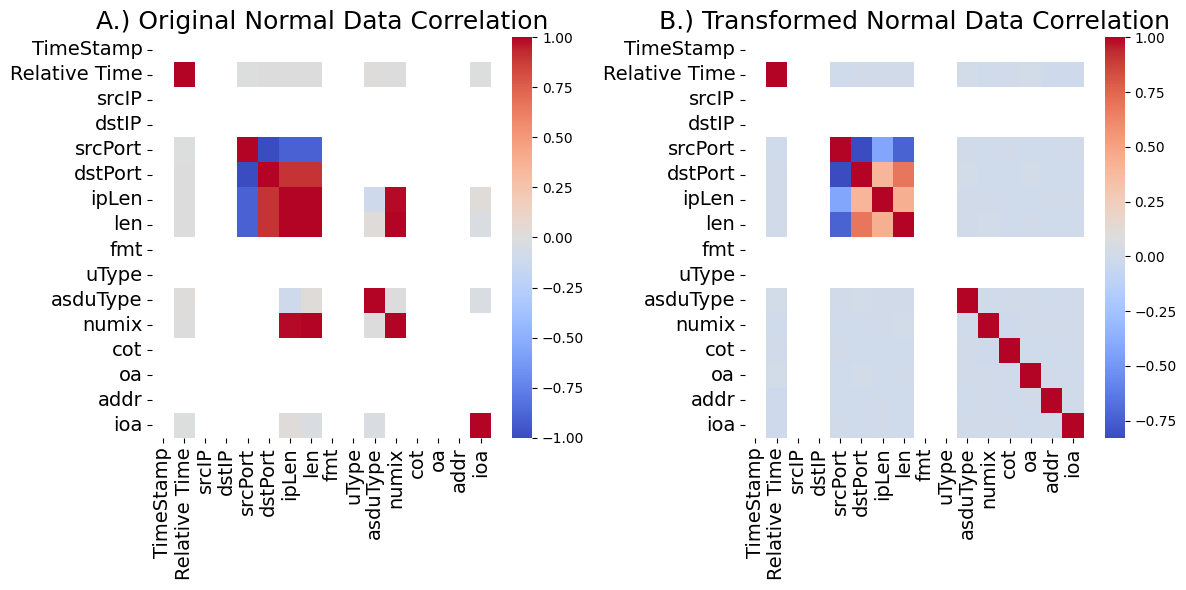

Data Transformed After Transformation shape: (411474, 17)
Data Transformed After Dropping NaN Columns shape: (411474, 12)
Features Transformed shape: (411474, 11)
Features Cleaned shape: (411474, 12)
Euclidean Distance: Mean = 40901.68169797026, Std Dev = 23427.66970542417


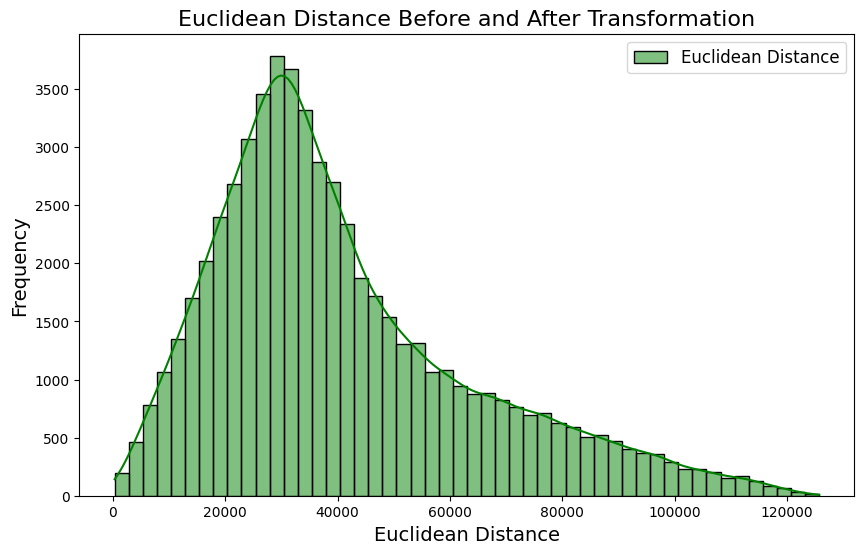

X_train shape: (288031, 11)
X_test shape: (123443, 11)
X_train_resampled shape: (444204, 11)
5-Fold Cross-Validation Accuracy: Mean = 1.00, Std Dev = 0.00


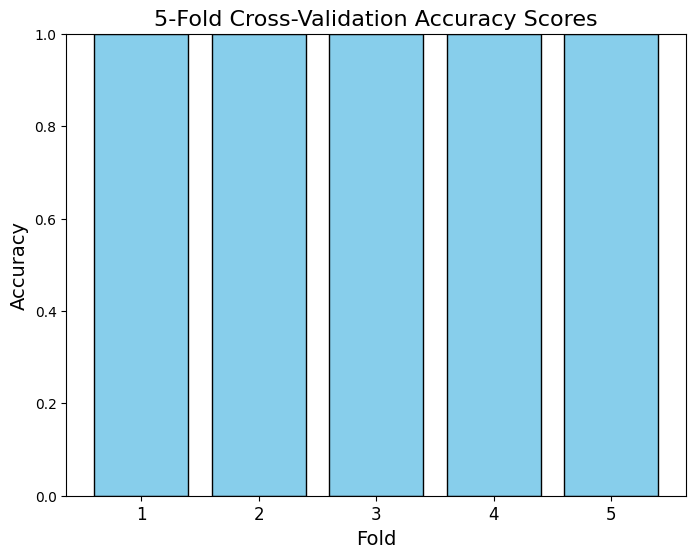

Train Accuracy: 1.00
Test Accuracy: 1.00


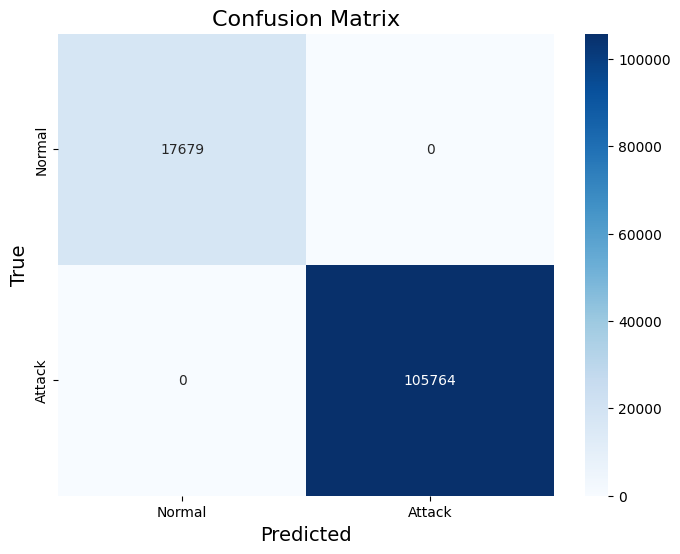

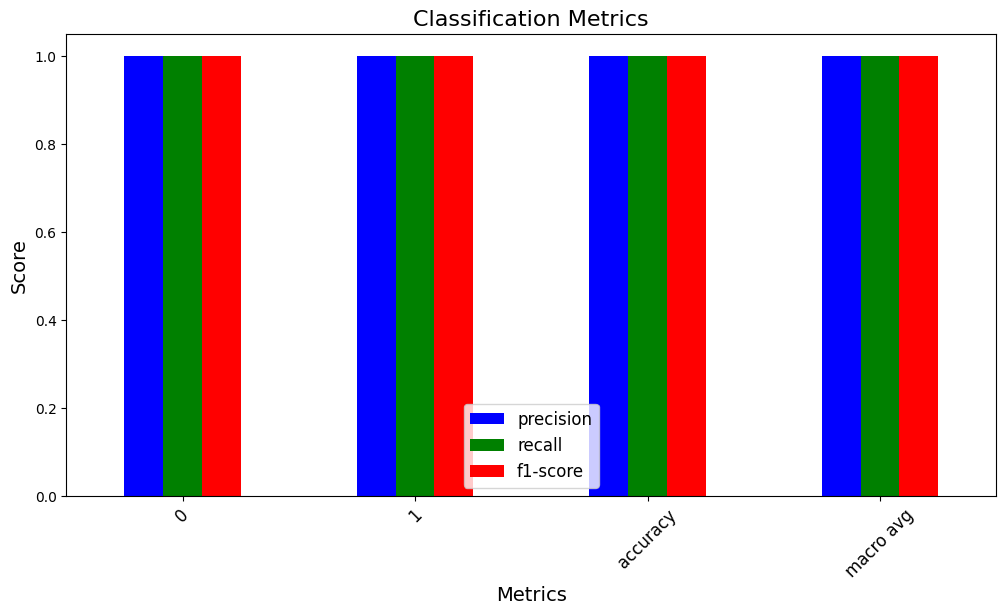

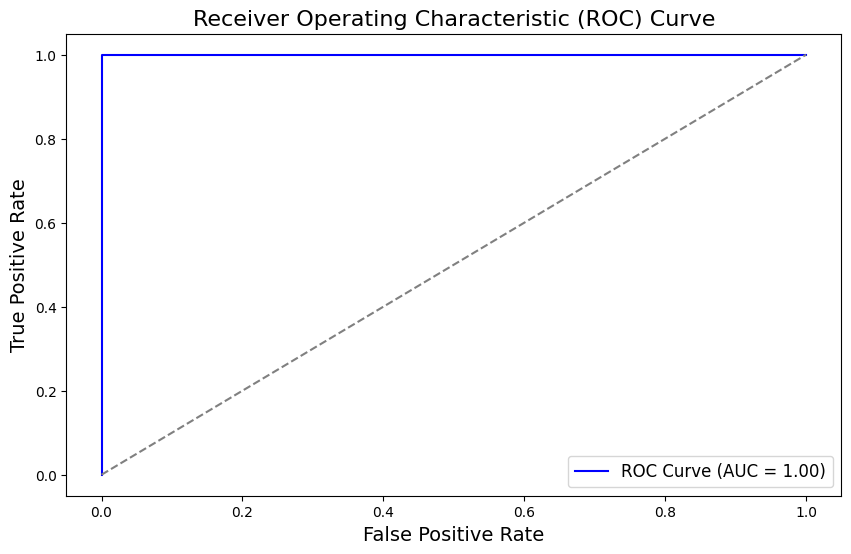

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cosine, euclidean

# Debugging function to check shape alignment
def debug_shape(df, name="DataFrame"):
    print(f"{name} shape: {df.shape}")

# Function to safely load CSV files
def safe_load_csv(filepath):
    try:
        return pd.read_csv(filepath, delimiter=';', encoding='utf-8')
    except pd.errors.ParserError:
        print(f"Error loading {filepath}. Attempting to skip problematic rows...")
        return pd.read_csv(filepath, on_bad_lines='skip', delimiter=';', encoding='utf-8')


normal = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/normal-traffic.csv")
connection_loss = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/connection-loss.csv")
switching_attack = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/switching-attack.csv")
scanning_attack = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/scanning-attack.csv")
dos_attack = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/dos-attack.csv")
rogue_devices = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/rogue-device.csv")
injection_attack = safe_load_csv("/Users/bodapati/Desktop/Eoc project/ICS Dataset for Smart Grid Anomaly Detection/ics-dataset-for-smart-grids/but-iec104-i/injection-attack.csv")

# 2. Assign labels
normal['label'] = 0
for df in [connection_loss, switching_attack, scanning_attack, dos_attack, rogue_devices, injection_attack]:
    df['label'] = 1

# Combine all data
data = pd.concat([normal, connection_loss, switching_attack, scanning_attack, dos_attack, rogue_devices, injection_attack], ignore_index=True)
debug_shape(data, "Combined Data")

# Check for mixed or improperly parsed columns and clean
def clean_data_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

data = clean_data_columns(data)

# 3. Apply a stronger transformation to normal data
def transform_normal_data(data, noise_level=0.5):
    noise = np.random.normal(0, noise_level, data.shape)
    scaled_data = data * np.random.uniform(0.5, 1.5, data.shape)
    transformed_data = scaled_data + noise
    return transformed_data

normal_features = data[data['label'] == 0].drop(columns=['label'])
debug_shape(normal_features, "Normal Features Before Transformation")

# Apply transformation to normal data
transformed_normal_features = transform_normal_data(normal_features.to_numpy(), noise_level=0.5)
transformed_normal = pd.DataFrame(transformed_normal_features, columns=normal_features.columns)
transformed_normal['label'] = 0
debug_shape(transformed_normal, "Transformed Normal Data")

# Plot original and transformed normal data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(normal_features.corr(), cmap='coolwarm', annot=False)
plt.title('A.) Original Normal Data Correlation', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(transformed_normal_features, columns=normal_features.columns).corr(), cmap='coolwarm', annot=False)
plt.title('B.) Transformed Normal Data Correlation', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

# Combine transformed normal data back with other classes
other_classes = data[data['label'] != 0]
data_transformed = pd.concat([transformed_normal, other_classes], ignore_index=True)
debug_shape(data_transformed, "Data Transformed After Transformation")

# Ensure consistency in data cleaning
data_transformed = clean_data_columns(data_transformed)

# 4. Handle missing values
non_nan_columns = data_transformed.columns[data_transformed.notna().any()].tolist()
data_transformed = data_transformed[non_nan_columns]
debug_shape(data_transformed, "Data Transformed After Dropping NaN Columns")

# Separate features and labels
features_transformed = data_transformed.drop(columns=['label'])
label_transformed = data_transformed['label']
debug_shape(features_transformed, "Features Transformed")

# Impute missing values
imputer = SimpleImputer(strategy='median')
features_cleaned = imputer.fit_transform(features_transformed)

# Ensure column alignment
features_cleaned_df = pd.DataFrame(features_cleaned, columns=features_transformed.columns)
features_cleaned_df['label'] = label_transformed.reset_index(drop=True)
debug_shape(features_cleaned_df, "Features Cleaned")

# 5. Feature selection and preprocessing
scaler = StandardScaler()
numerical_features = [col for col in features_cleaned_df.columns if col != 'label']
features_cleaned_df[numerical_features] = scaler.fit_transform(features_cleaned_df[numerical_features])
features_cleaned_df['label'] = features_cleaned_df['label'].astype(int)

# Ensure no NaN or inf values in normal_features and transformed_normal_features
normal_features_clean = np.nan_to_num(normal_features.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)
transformed_normal_features_clean = np.nan_to_num(transformed_normal_features, nan=0.0, posinf=0.0, neginf=0.0)

euclidean_distances = [euclidean(original, transformed) 
                       for original, transformed in zip(normal_features_clean, transformed_normal_features_clean)]

euclidean_mean = np.mean(euclidean_distances)
euclidean_std = np.std(euclidean_distances)

print(f"Euclidean Distance: Mean = {euclidean_mean}, Std Dev = {euclidean_std}")

# Plot Euclidean Distance
plt.figure(figsize=(10, 6))
sns.histplot(euclidean_distances, kde=True, bins=50, color='green', label='Euclidean Distance')
plt.title('Euclidean Distance Before and After Transformation', fontsize=16)
plt.xlabel('Euclidean Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 6. Split data
X = features_cleaned_df.drop(columns=['label'])
y = features_cleaned_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
debug_shape(X_train, "X_train")
debug_shape(X_test, "X_test")

# 7. Handle imbalance using SMOTE
smote = SMOTE(sampling_strategy={0: int(y_train.value_counts()[1] * 0.8)}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
debug_shape(X_train_resampled, "X_train_resampled")

# 8. Perform 5-fold cross-validation
clf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"5-Fold Cross-Validation Accuracy: Mean = {cv_scores.mean():.2f}, Std Dev = {cv_scores.std():.2f}")

# Plot cross-validation scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
plt.title('5-Fold Cross-Validation Accuracy Scores', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, 6), fontsize=12)
plt.ylim(0, 1)
plt.show()

# 9. Train classifier on full resampled training data
clf.fit(X_train_resampled, y_train_resampled)

# 10. Calculate and print train and test accuracy
y_train_pred = clf.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# 11. Evaluate the model
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, output_dict=True)

# Generate ROC Curve
y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

# Metrics Plot
metrics_df = pd.DataFrame(report).transpose().iloc[:-1, :3]
metrics_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'green', 'red'])
plt.title('Classification Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(fontsize=12)
plt.show()

# ROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.show()